# King County Housing EDA

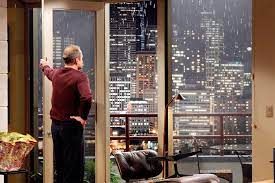

# 0. Importing modules

In [478]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import geopandas as gpd
import re
from scipy.spatial.distance import cdist
import calendar

from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

# 1. Data

## We are looking at a Data Set containing information about home sales in King County (USA)

#### So how does the data look like. Lets see!

In [447]:

df = pd.read_csv('data/King_County_House_prices_dataset.csv')
zip_shape_df = gpd.read_file('data/Zipcodes/Zipcodes_for_King_County_and_Surrounding_Area_(Shorelines)___zipcode_shore_area.shp') #loading some geo information about the zip areas in king county
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.000,3,1.000,1180,5650,1.000,NaN,0.000,...,7,1180,0.0,1955,0.000,98178,47.511,-122.257,1340,5650
1,6414100192,12/9/2014,538000.000,3,2.250,2570,7242,2.000,0.000,0.000,...,7,2170,400.0,1951,1991.000,98125,47.721,-122.319,1690,7639
2,5631500400,2/25/2015,180000.000,2,1.000,770,10000,1.000,0.000,0.000,...,6,770,0.0,1933,NaN,98028,47.738,-122.233,2720,8062
3,2487200875,12/9/2014,604000.000,4,3.000,1960,5000,1.000,0.000,0.000,...,7,1050,910.0,1965,0.000,98136,47.521,-122.393,1360,5000
4,1954400510,2/18/2015,510000.000,3,2.000,1680,8080,1.000,0.000,0.000,...,8,1680,0.0,1987,0.000,98074,47.617,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.000,3,2.500,1530,1131,3.000,0.000,0.000,...,8,1530,0.0,2009,0.000,98103,47.699,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.000,4,2.500,2310,5813,2.000,0.000,0.000,...,8,2310,0.0,2014,0.000,98146,47.511,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.000,2,0.750,1020,1350,2.000,0.000,0.000,...,7,1020,0.0,2009,0.000,98144,47.594,-122.299,1020,2007
21595,291310100,1/16/2015,400000.000,3,2.500,1600,2388,2.000,NaN,0.000,...,8,1600,0.0,2004,0.000,98027,47.535,-122.069,1410,1287


We have 21 data columns with 21597 rows of data. 

### Lets get some more information about the dataframe

In [448]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Most of the columns are numbers but two of the columns use the datatype 'object': 'date' which could be the date as a string, and 'sqft_basement' lets find out later why this is the case

Also there are 3 columns with NaN values, we later should think about how we will handle with this NaNs

### Lets get some short descriptive statistics about the data set

In [449]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,19221.000,21534.000,21597.000,21597.000,21597.000,21597.000,17755.000,21597.000,21597.000,21597.000,21597.000,21597.000
mean,4580474287.771,540296.574,3.373,2.116,2080.322,15099.409,1.494,0.008,0.234,3.410,7.658,1788.597,1971.000,83.637,98077.952,47.560,-122.214,1986.620,12758.284
std,2876735715.748,367368.140,0.926,0.769,918.106,41412.637,0.540,0.087,0.766,0.651,1.173,827.760,29.375,399.946,53.513,0.139,0.141,685.230,27274.442
min,1000102.000,78000.000,1.000,0.500,370.000,520.000,1.000,0.000,0.000,1.000,3.000,370.000,1900.000,0.000,98001.000,47.156,-122.519,399.000,651.000
25%,2123049175.000,322000.000,3.000,1.750,1430.000,5040.000,1.000,0.000,0.000,3.000,7.000,1190.000,1951.000,0.000,98033.000,47.471,-122.328,1490.000,5100.000
50%,3904930410.000,450000.000,3.000,2.250,1910.000,7618.000,1.500,0.000,0.000,3.000,7.000,1560.000,1975.000,0.000,98065.000,47.572,-122.231,1840.000,7620.000
75%,7308900490.000,645000.000,4.000,2.500,2550.000,10685.000,2.000,0.000,0.000,4.000,8.000,2210.000,1997.000,0.000,98118.000,47.678,-122.125,2360.000,10083.000
max,9900000190.000,7700000.000,33.000,8.000,13540.000,1651359.000,3.500,1.000,4.000,5.000,13.000,9410.000,2015.000,2015.000,98199.000,47.778,-121.315,6210.000,871200.000


# 2. Hypotheses

### Lets think about three hypthoses we could ask us:

* buying a house in a city is more pricy than buying a house in the country side.
* house prices correlate with the house age
* the house prices depend on the season of year


#### Also we want to help our stakeholder Thomas Hansen to buy a house. Here are some important things about Thomas:
* Thomas is mid-age with a badly paid job at a callcenter
* thomas is marired and has 5 children
* Thomas likes to live in a social environment

#### Thomas wants to buy a house but has little money. He needs help with buying a house. So this three recommendations he needs:
* Best locations for cheap houses, which are social friendly
* Best time of the year to buy a house
* What features does he have to do without in order to find an affordable house?

# 3. Data Cleaning

In [450]:
df.date = pd.to_datetime(df.date)
df.yr_renovated = pd.to_datetime(df.yr_renovated)
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,19221.000,21534.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000
mean,4580474287.771,540296.574,3.373,2.116,2080.322,15099.409,1.494,0.008,0.234,3.410,7.658,1788.597,1971.000,98077.952,47.560,-122.214,1986.620,12758.284
std,2876735715.748,367368.140,0.926,0.769,918.106,41412.637,0.540,0.087,0.766,0.651,1.173,827.760,29.375,53.513,0.139,0.141,685.230,27274.442
min,1000102.000,78000.000,1.000,0.500,370.000,520.000,1.000,0.000,0.000,1.000,3.000,370.000,1900.000,98001.000,47.156,-122.519,399.000,651.000
25%,2123049175.000,322000.000,3.000,1.750,1430.000,5040.000,1.000,0.000,0.000,3.000,7.000,1190.000,1951.000,98033.000,47.471,-122.328,1490.000,5100.000
50%,3904930410.000,450000.000,3.000,2.250,1910.000,7618.000,1.500,0.000,0.000,3.000,7.000,1560.000,1975.000,98065.000,47.572,-122.231,1840.000,7620.000
75%,7308900490.000,645000.000,4.000,2.500,2550.000,10685.000,2.000,0.000,0.000,4.000,8.000,2210.000,1997.000,98118.000,47.678,-122.125,2360.000,10083.000
max,9900000190.000,7700000.000,33.000,8.000,13540.000,1651359.000,3.500,1.000,4.000,5.000,13.000,9410.000,2015.000,98199.000,47.778,-121.315,6210.000,871200.000


In [451]:
# See what other character can be found in the sqft_basement column
df[df.sqft_basement.str.findall('[^0-9.]+').str.len() != 0].sqft_basement.unique()

array(['?'], dtype=object)

We now know that the column is no float object because there are rows with an "?" instead of a number

We can replace the ? with a NaN

In [452]:
df.sqft_basement = df.sqft_basement.replace('?',np.NaN)
df.sqft_basement = pd.to_numeric(df.sqft_basement)
df.sqft_basement.info()



<class 'pandas.core.series.Series'>
RangeIndex: 21597 entries, 0 to 21596
Series name: sqft_basement
Non-Null Count  Dtype  
--------------  -----  
21143 non-null  float64
dtypes: float64(1)
memory usage: 168.9 KB


Let's look for NaN's and what we can do with them

In [453]:
df.columns[df.isna().any()].tolist() #columns with NaNs
df.isna().sum()/df.shape[0]*100

#df.view[df.view != 0]


id               0.000
date             0.000
price            0.000
bedrooms         0.000
bathrooms        0.000
sqft_living      0.000
sqft_lot         0.000
floors           0.000
waterfront      11.002
view             0.292
condition        0.000
grade            0.000
sqft_above       0.000
sqft_basement    2.102
yr_built         0.000
yr_renovated    17.790
zipcode          0.000
lat              0.000
long             0.000
sqft_living15    0.000
sqft_lot15       0.000
dtype: float64

* yr_renovated could be NaN because the house was not renovated yet. We can leave the NaNs but keep them in mind when working with this column.
* sqft_basement: For this column we can calculate the missing numbers by assuming that the basement_space = living_space - above_space
* the small percentage (0.3 %) of missing values of view will not be changed for now
* for waterfront lets have a look at the map and see if one of the houses with missing values is actually near water


(47.2, 47.6)

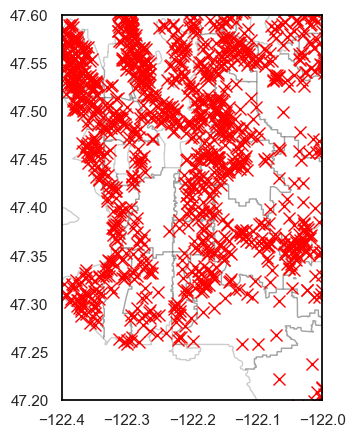

In [454]:
# replacing NaNs of sqft_basement with sqft_living - sqft_above
df.sqft_basement = df.sqft_basement.fillna(df.sqft_living - df.sqft_above)

#have a look at the map with houses with missing values in "waterfront"
fig, ax = plt.subplots()
df_water_nan = df[df.waterfront.isna()]
zip_shape_df[zip_shape_df.ZIP.isin(df_water_nan.zipcode)].plot(ax=ax, color='None', edgecolor='black', alpha=0.2)
ax.plot(df_water_nan.long,df_water_nan.lat,'x',markersize=8,color='red')
ax.set_xlim(-122.4,-122)
ax.set_ylim(47.2,47.6)

As you could see it seems that there are houses right at the water. 

What we will do next is to find out the nearest houses to the houses with waterfront = NaN

Than we will replace the NaN value with the Value of the nearest house.

In [455]:
def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]



df['point'] = [(x, y) for x,y in zip(df['long'], df['lat'])]

df_water_nan = df[df.waterfront.isna()]
df_water_notnan = df[df.waterfront.notna()]



df_water_nan['closest'] = [closest_point(x, list(df_water_notnan['point'])) for x in df_water_nan['point']]
df_water_nan_m = df_water_nan.reset_index().merge(df_water_notnan[['waterfront','point']],how = 'left',left_on = 'closest', right_on='point', suffixes = ('_this', '_nearest')).set_index('index')

df = pd.merge(df,df_water_nan_m[['id','waterfront_nearest']],on='id',how='left')

df.waterfront = df.waterfront.fillna(df.waterfront_nearest)
df.waterfront.isna().sum()
df.drop('waterfront_nearest',axis=1,inplace = True)


## create some year/month/weekday columns from the date column

In [456]:
df['year_sold'] = df.date.dt.year
df['month_sold'] = df.date.dt.month
df['weekday_sold'] = df.date.dt.weekday
df['time_diff'] = df['year_sold'] - df['yr_built']
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,point,year_sold,month_sold,weekday_sold,time_diff
0,7129300520,2014-10-13,221900.000,3,1.000,1180,5650,1.000,0.000,0.000,...,98178,47.511,-122.257,1340,5650,"(-122.257, 47.5112)",2014,10,0,59
1,6414100192,2014-12-09,538000.000,3,2.250,2570,7242,2.000,0.000,0.000,...,98125,47.721,-122.319,1690,7639,"(-122.319, 47.721)",2014,12,1,63
2,5631500400,2015-02-25,180000.000,2,1.000,770,10000,1.000,0.000,0.000,...,98028,47.738,-122.233,2720,8062,"(-122.233, 47.7379)",2015,2,2,82
3,2487200875,2014-12-09,604000.000,4,3.000,1960,5000,1.000,0.000,0.000,...,98136,47.521,-122.393,1360,5000,"(-122.393, 47.5208)",2014,12,1,49
4,1954400510,2015-02-18,510000.000,3,2.000,1680,8080,1.000,0.000,0.000,...,98074,47.617,-122.045,1800,7503,"(-122.045, 47.6168)",2015,2,2,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21711,6600060120,2015-02-23,400000.000,4,2.500,2310,5813,2.000,0.000,0.000,...,98146,47.511,-122.362,1830,7200,"(-122.362, 47.5107)",2015,2,0,1
21712,1523300141,2014-06-23,402101.000,2,0.750,1020,1350,2.000,0.000,0.000,...,98144,47.594,-122.299,1020,2007,"(-122.299, 47.5944)",2014,6,0,5
21713,291310100,2015-01-16,400000.000,3,2.500,1600,2388,2.000,0.000,0.000,...,98027,47.535,-122.069,1410,1287,"(-122.069, 47.5345)",2015,1,4,11
21714,291310100,2015-01-16,400000.000,3,2.500,1600,2388,2.000,0.000,0.000,...,98027,47.535,-122.069,1410,1287,"(-122.069, 47.5345)",2015,1,4,11


# 3. Preparing a Map

[Text(1, 110.0, '<= 110'),
 Text(1, 1355.0, '1355'),
 Text(1, 2600.0, '2600'),
 Text(1, 3845.0, '3845'),
 Text(1, 5090.0, '5090'),
 Text(1, 6335.0, '6335'),
 Text(1, 7580.0, '7580'),
 Text(1, 8825.0, '8825'),
 Text(1, 10070.0, '10070'),
 Text(1, 11315.0, '11315'),
 Text(1, 12560.0, '>= 12560')]

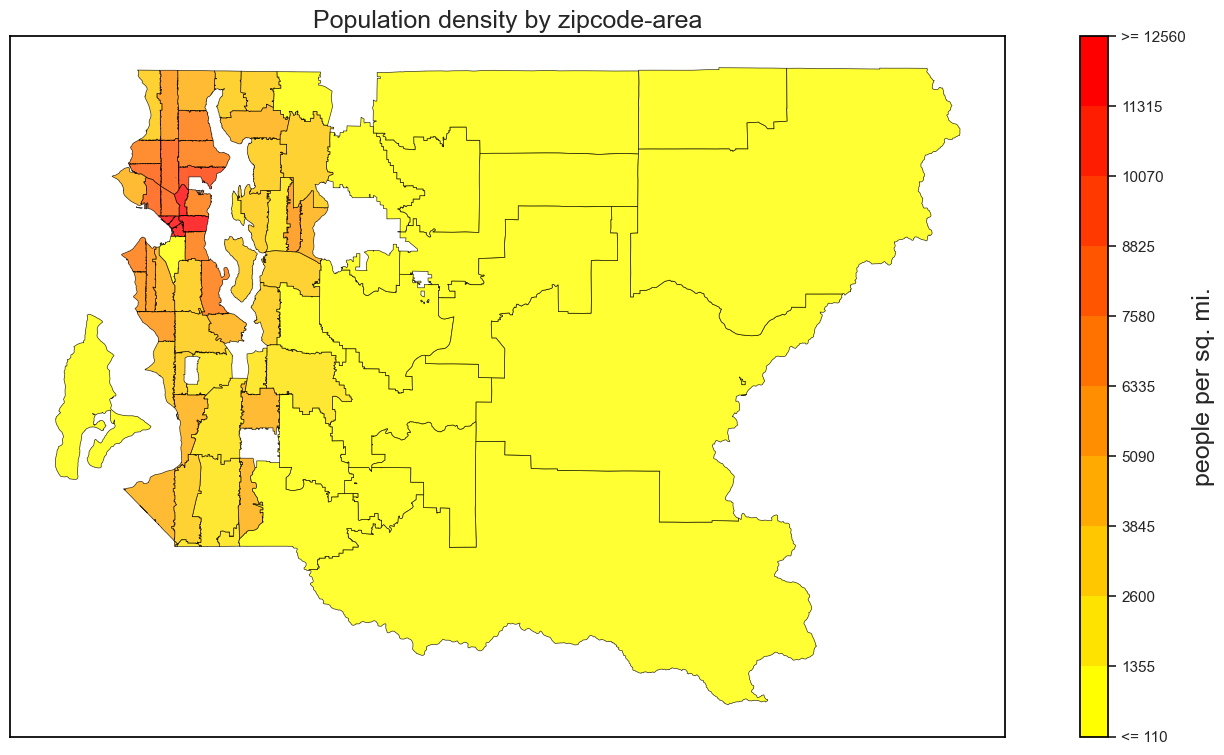

In [567]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

zip_shape_df = gpd.read_file('data/Zipcodes/Zipcodes_for_King_County_and_Surrounding_Area_(Shorelines)___zipcode_shore_area.shp')
zip_shape_df = zip_shape_df[zip_shape_df.COUNTY_NAM == 'King County']
countys = gpd.read_file('data/us_countys/USA_adm2.shp')
king_county_shape = countys[countys.NAME_2 == 'King'][countys.NAME_1 == 'Washington']
states = gpd.read_file('data/us_countys/USA_adm1.shp')
washington_shape = states[states.NAME_1 == 'Washington']


pop_dens = pd.read_csv('data/us_population_density_by_zip_september2020.csv')
pop_dens = pop_dens.rename({'zip':'ZIP'},inplace=False,axis=1)
zip_shape_df= zip_shape_df.merge(pop_dens[['ZIP','population','population_density']],how='left',on='ZIP')



cmap = plt.cm.autumn_r  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
#cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(np.round(zip_shape_df.population_density.quantile(q=0.05),-1), np.round(zip_shape_df.population_density.quantile(q=0.95),-1), 11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, clip = True)





#fig, [ax1, ax2]= plt.subplots(1,2,gridspec_kw={'width_ratios': [50, 1]},figsize=(12, 6))
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(10, 4),gridspec_kw={'width_ratios': [50, 1]},)
plt.tight_layout(pad=-10)
#king_county_shape.plot(ax=ax1, color='white', edgecolor='black', linewidth=1, alpha=0.2)
zip_shape_df.plot(ax=ax1, edgecolor='black', alpha=0.8, column='population_density',cmap=cmap,categorical = False,linewidth=0.5,norm = norm,legend=False)

cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
     spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

ax1.tick_params(
    axis='both', bottom=False, left=False,         
    labelbottom=False, labelleft=False) 

ax1.set_title('Population density by zipcode-area', size=18)
ax2.set_ylabel('people per sq. mi.', size=18)

labels = [item.get_text() for item in ax2.get_yticklabels()]
labels[0] = '<= ' + labels[0]
labels[-1] = '>= ' + labels[-1] 
ax2.set_yticklabels(labels)

# 

## Group the data by zipcode

In [458]:

df_zip = df.groupby('zipcode').mean().reset_index().merge(zip_shape_df[['ZIP','population','population_density']],left_on='zipcode',right_on='ZIP')
df_zip.drop('ZIP',axis=1,inplace=True)
df_zip


,zipcode,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,year_sold,month_sold,weekday_sold,time_diff,population,population_density
0,98001,4651273623.072,281194.870,3.393,2.012,1903.784,14967.003,1.431,0.000,0.095,...,47.309,-122.271,1830.100,11218.875,2014.321,6.568,2.119,33.454,25771.000,1408.910
1,98002,4850894131.724,234284.035,3.327,1.839,1627.744,7517.633,1.334,0.000,0.010,...,47.309,-122.213,1479.030,7585.482,2014.337,6.698,2.121,46.563,30815.000,4053.550
2,98003,4672573484.947,293865.331,3.356,2.047,1927.214,10592.907,1.310,0.000,0.214,...,47.316,-122.310,1875.000,9738.698,2014.342,6.633,1.986,37.488,42255.000,3478.650
3,98004,4407859198.031,1354522.343,3.849,2.525,2904.811,13066.497,1.437,0.003,0.306,...,47.616,-122.205,2672.390,12768.403,2014.340,6.349,1.987,42.758,22650.000,3055.730
4,98005,4961872170.542,810289.696,3.851,2.424,2656.804,19928.786,1.280,0.000,0.095,...,47.612,-122.167,2567.863,18367.774,2014.298,6.923,1.881,44.554,17089.000,2106.220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,98177,3934998241.741,676419.392,3.396,2.100,2323.333,11904.404,1.276,0.004,0.815,...,47.742,-122.369,2186.196,11690.239,2014.290,6.565,2.039,53.447,18920.000,3188.910
66,98178,4291467000.687,310612.756,3.305,1.732,1729.351,8309.122,1.185,0.038,0.534,...,47.499,-122.247,1648.817,8149.641,2014.294,6.885,2.160,59.061,21860.000,4386.270
67,98188,4480464026.616,288902.210,3.435,1.868,1807.370,10132.138,1.225,0.000,0.145,...,47.447,-122.281,1636.478,9764.268,2014.391,6.203,2.087,49.051,22583.000,2252.390
68,98198,5161308956.078,302744.082,3.185,1.788,1745.662,10507.648,1.224,0.032,0.595,...,47.391,-122.316,1709.181,9471.555,2014.349,6.448,1.954,47.630,33561.000,4488.330


,zipcode,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,year_sold,month_sold,weekday_sold,time_diff,population,population_density
zipcode,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bedrooms,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bathrooms,NaN,NaN,NaN,NaN,1.000,0.933,NaN,NaN,NaN,NaN,...,NaN,NaN,0.926,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sqft_living,NaN,NaN,NaN,NaN,0.933,1.000,NaN,NaN,NaN,NaN,...,NaN,NaN,0.980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sqft_lot,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,...,NaN,NaN,NaN,0.994,NaN,NaN,NaN,NaN,NaN,NaN
floors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
waterfront,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
view,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


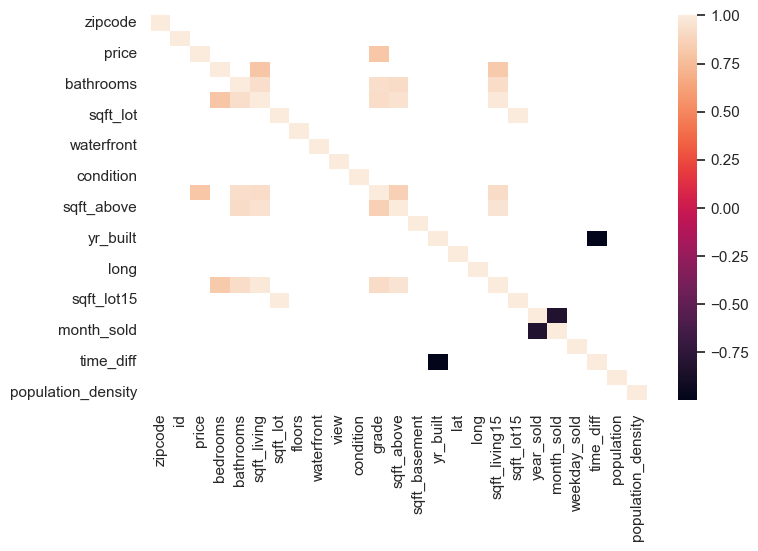

In [459]:

#sns.jointplot(ax=ax,data=df_zip,x='population',y='price', kind="kde")
sns.set(style="white")
g= sns.heatmap(df_zip.corr()[np.abs(df_zip.corr()) > 0.80])
cr = df_zip.corr()
cr = cr[np.abs(cr) > 0.85]
cr

## Group by year, month, weekday

Text(59.875, 0.5, 'price in US$')

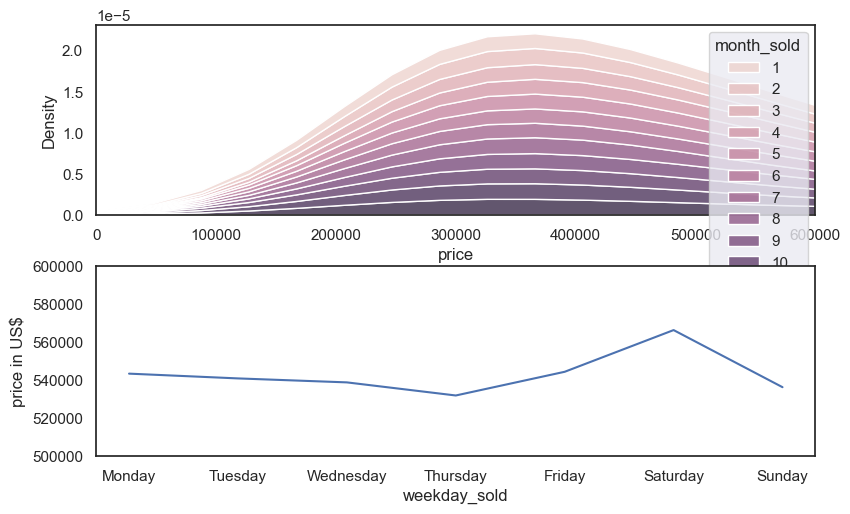

In [460]:
fig, [ax1,ax2] = plt.subplots(2,1)
sns.set_style('darkgrid')
sns.set_palette('Set2')
plt.tight_layout()
f1 = sns.kdeplot(data=df,x='price',ax=ax1,hue = 'month_sold',multiple="stack",common_norm=False,common_grid=True)
f2 = sns.lineplot(data=df.groupby('weekday_sold').mean().reset_index(),x='weekday_sold',y='price',ax=ax2)
f2.set_xticks(np.arange(0,7,1))
f1.set_xlim(0,6e5)
#f1.set_xticks(np.arange(0,13,1))
#f1.set_xticklabels(labels=calendar.month_name)
f2.set_xticklabels(labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

f2.set_ylim(5e5,6e5)
#f1.set_ylim(5e5,6e5)
f2.set_ylabel('price in US$')


## Binning by Population density
### Answering Hypthoses 1

Text(0.5, 0, 'Population Density')

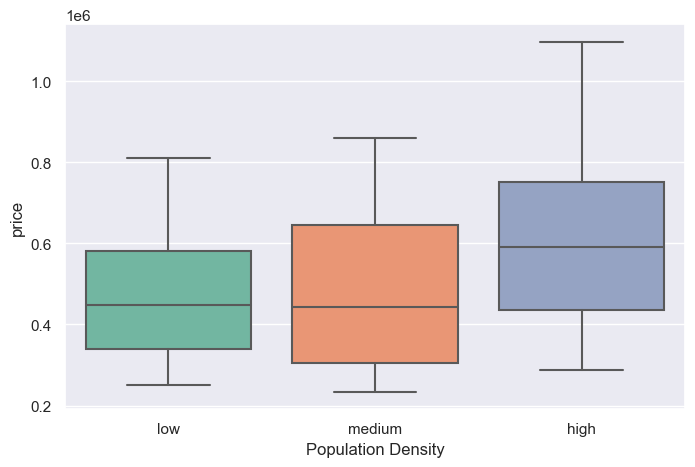

In [461]:
df_zip['q_pop_bins'], bins= pd.qcut(df_zip.population_density,3,retbins=True,labels=['low','medium','high'])

sns.set_style('darkgrid')
sns.set_palette('Set2')
fig, ax = plt.subplots()
sns.boxplot(x ='q_pop_bins',y='price',data=df_zip,ax=ax,showfliers = False)
ax.set_xlabel('Population Density')


## House prices correlate with the age of the house

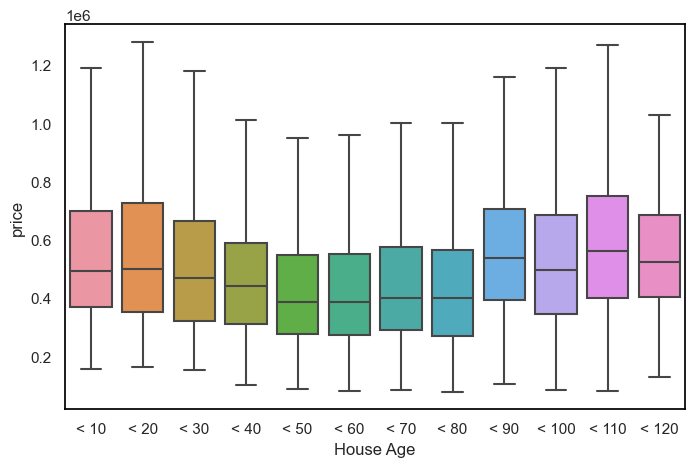

In [533]:
df['time_diff_bins'], bins= pd.cut(df.time_diff,list(range(0,130,10)),retbins=True, labels=['< 10','< 20','< 30','< 40','< 50','< 60','< 70','< 80','< 90','< 100','< 110','< 120'])
fig, ax = plt.subplots()
sns.boxplot(data=df,x='time_diff_bins',y='price',showfliers = False)
ax.set_xlabel('House Age')
plt.show()